In [1]:
from tqdm import tqdm
import pickle
from irt import *
from selection import *
from utils import *

random_state = 42

Definitions

In [2]:
scenarios = {'boolq:':['boolq:'],
             #'civil_comments':['civil_comments:demographic=LGBTQ,',
             #                  'civil_comments:demographic=all,',
             #                  'civil_comments:demographic=black,',
             #                  'civil_comments:demographic=christian,',
             #                  'civil_comments:demographic=female,',
             #                  'civil_comments:demographic=male,',
             #                  'civil_comments:demographic=muslim,',
             #                  'civil_comments:demographic=other_religions,',
             #                  'civil_comments:demographic=white,'],
             'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':['commonsense:dataset=hellaswag,method=multiple_choice_separate_original,'],
             'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':['commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,'],
             'imdb:':['imdb:'],
             'mmlu':['mmlu:subject=abstract_algebra,method=multiple_choice_joint,',
                     'mmlu:subject=college_chemistry,method=multiple_choice_joint,',
                     'mmlu:subject=computer_security,method=multiple_choice_joint,',
                     'mmlu:subject=econometrics,method=multiple_choice_joint,',
                     'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,'],
             'msmarco:track=regular,valid_topk=30,':['msmarco:track=regular,valid_topk=30,'],
             #'msmarco:track=trec,valid_topk=30,':['msmarco:track=trec,valid_topk=30,'],
             'narrative_qa:':['narrative_qa:'],
             'natural_qa:mode=closedbook,':['natural_qa:mode=closedbook,'],
             'natural_qa:mode=openbook_longans,':['natural_qa:mode=openbook_longans,'],
             'quac:':['quac:'],
             'raft':['raft:subset=ade_corpus_v2,',
                     'raft:subset=banking_77,',
                     'raft:subset=neurips_impact_statement_risks,',
                     'raft:subset=one_stop_english,',
                     'raft:subset=overruling,',
                     'raft:subset=semiconductor_org_types,',
                     'raft:subset=systematic_review_inclusion,',
                     'raft:subset=tai_safety_research,',
                     'raft:subset=terms_of_service,',
                     'raft:subset=tweet_eval_hate,',
                     'raft:subset=twitter_complaints,'],
             'truthful_qa:task=mc_single,method=multiple_choice_joint,':['truthful_qa:task=mc_single,method=multiple_choice_joint,']}
            
scenarios_metrics = {'boolq:':'em', 
                     'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':'em',
                     'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':'em',
                     'imdb:':'em', 
                     'mmlu':'em', 
                     'msmarco:track=regular,valid_topk=30,':'RR@10', 
                     'msmarco:track=trec,valid_topk=30,':'NDCG@10', 
                     'narrative_qa:':'f1', 
                     'natural_qa:mode=closedbook,':'f1', 
                     'natural_qa:mode=openbook_longans,':'f1', 
                     'quac:':'f1', 
                     'raft':'em', 
                     'truthful_qa:task=mc_single,method=multiple_choice_joint,':'em'}

## Data

Loading data

In [3]:
with open('data/helm.pickle', 'rb') as handle:
    data = pickle.load(handle)

## Results

In [4]:
dropout = .5 #default .5
hidden = 100 #default 100
epochs = 2000 #default 2000
lr = .1 #default .1
device = 'cuda'
balance = True
tune_alpha = False

num_elements = 4
iterations = 10
tune_iterations = 3
number_items = [10, 25, 50, 75, 100]
Ds = [15, 20, 25]
alphas = [None, 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
set_of_rows = create_sublists_corrected(list(range(len(data['models']))), num_elements)
set_of_rows

NameError: name 'create_sublists_corrected' is not defined

### Predicting accuracy

In [ ]:
scenario_name = 'full' #scenario
scenarios_choosen = list(scenarios.keys())

accs = {}
results = {}

count = 0

for rows_to_hide in tqdm(set_of_rows):
    rows_to_hide_str = ':'.join([str(r) for r in rows_to_hide])
        
    ### Prep data
    scenarios_position, subscenarios_position = prepare_data(scenarios_choosen, scenarios, data)
    scores = create_responses(scenarios_choosen, scenarios, data)
    scores_train = scores[[i for i in range(scores.shape[0]) if i not in rows_to_hide]]
    scores_test = scores[[i for i in range(scores.shape[0]) if i in rows_to_hide]]
    responses_train = np.zeros(scores_train.shape)
    responses_test = np.zeros(scores_test.shape)

    cs = np.linspace(0.01,.99,1000)
    for scenario in scenarios_choosen:
        ind = scenarios_position[scenario]
        c = cs[np.argmin([np.mean((np.abs((scores_train[:,ind]>c).mean(axis=1)-scores_train[:,ind].mean(axis=1)))) for c in cs])]
        responses_train[:,ind] = (scores_train[:,ind]>c).astype(int)
        responses_test[:,ind] = (scores_test[:,ind]>c).astype(int)
        
    ### Choosing D
    train_ind = list(range(0,responses_train.shape[0],2))
    val_ind = [i for i in range(responses_train.shape[0]) if i not in train_ind]
    responses_train[train_ind].shape

    dataset_name = f'data/irt_helm/rows-{rows_to_hide_str}_scenario-{scenario_name}_val_all_models3.jsonlines'
    create_irt_dataset(responses_train[train_ind], dataset_name)

    errors = []
    for D in Ds:
        model_name = f'models/irt_helm/rows-{rows_to_hide_str}_D-{D}_scenario-{scenario_name}_val_all_models3/'
        train_irt_model(dataset_name, model_name, D, hidden, dropout, lr, epochs, device)
        A, B, Theta = load_irt_parameters(model_name)
        seen_items, unseen_items, _ = select_initial_adaptive_items(A, B, Theta, 2*D)
        errors2 = []
        for it in range(tune_iterations):
            random.seed(random_state*it)
            seen_items, unseen_items = get_seen_unseen_items(scenarios_choosen, scenarios, number_items[0], subscenarios_position, responses_test)
            thetas = [estimate_ability_parameters(responses_train[val_ind][j], seen_items, A, B) for j in range(len(val_ind))]
            errors2.append(np.mean([abs(responses_train[val_ind][j,unseen_items].mean()-item_curve(thetas[j], A, B)[0,unseen_items].mean()) for j in range(len(val_ind))]))
        errors.append(np.mean(errors2))
    D = Ds[np.argmin(errors)]
    print("\nD", D, errors,"\n")
    
    ### Choosing alphas
    if tune_alpha:
        model_name = f'models/irt_helm/rows-{rows_to_hide_str}_D-{D}_scenario-{scenario_name}_val_all_models3/'
        A, B, Theta = load_irt_parameters(model_name)
        opt_alphas = {}
        for scenario in scenarios_choosen:
            opt_alphas[scenario] = {}
            for number_item in number_items:
                errors = []
                for it in range(iterations):
                    random.seed(random_state*it)
                    seen_items, unseen_items = get_seen_unseen_items(scenarios_choosen, scenarios, number_item, subscenarios_position, responses_test)
                    thetas = [estimate_ability_parameters(responses_train[val_ind][j], seen_items, A, B) for j in range(len(val_ind))]
                    errors.append(np.array([[abs(scores_train[val_ind][j][scenarios_position[scenario]].mean()-compute_acc_irt(scenario, scores_train[val_ind][j], scenarios_position, seen_items, unseen_items, A, B, thetas[j], alpha=alpha)) for alpha in alphas] for j in range(len(val_ind))]).mean(axis=0))
                opt_alphas[scenario][number_item] = alphas[np.argmin(np.array(errors).mean(axis=0))]
                print(scenario, number_item, opt_alphas[scenario][number_item], np.min(np.array(errors).mean(axis=0)), np.array(errors).mean(axis=0))
        print(opt_alphas)
    
    else:  
        opt_alphas = {}
        for scenario in scenarios_choosen:
            opt_alphas[scenario] = {}
            for number_item in number_items:
                opt_alphas[scenario][number_item] = None

    ### Saving dataset
    dataset_name = f'data/irt_helm/row-{rows_to_hide_str}_scenario-{scenario_name}_all_models3.jsonlines'
    create_irt_dataset(responses_train, dataset_name)

    ### Train final IRT model
    model_name = f'models/irt_helm/row-{rows_to_hide_str}_D-validate_scenario-{scenario_name}_all_models3/'
    train_irt_model(dataset_name, model_name, D, hidden, dropout, lr, epochs, device)

    ### Load IRT model
    A, B, Theta = load_irt_parameters(model_name)
        
    ### Creating storage space in acc and results to store new results
    [create_space_accs_results(accs, results, r, number_items, scenarios_choosen) for r in rows_to_hide]
        
    ### Running adaptive evaluation
    for j in tqdm(range(len(rows_to_hide))):

        seen_items, unseen_items, mats = select_initial_adaptive_items(A, B, Theta, 2*D) #number_items[0]

        for number_item in number_items:

            # Number of samples
            target_count = len(scenarios_choosen)*number_item

            # Sampling new items  
            seen_items, unseen_items = run_adaptive_selection(responses_test[j], seen_items, unseen_items, scenarios_choosen, scenarios_position, A, B, mats, target_count, balance=balance)

            # Running IRT in the remaining sample 
            new_theta = estimate_ability_parameters(responses_test[j], seen_items, A, B)

            # Updating 'accs' and 'results'
            for scenario in scenarios_choosen:
                alpha = opt_alphas[scenario][number_item]
                accs[rows_to_hide[j]][number_item]['adaptive_irt'][scenario].append(compute_acc_irt(scenario, scores_test[j], scenarios_position, seen_items, unseen_items, A, B, new_theta, alpha=alpha))
            update_results('adaptive_irt', scores_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, accs, results, number_item)
        
    ### Running random evaluation
    for j in tqdm(range(len(rows_to_hide))):

        for number_item in number_items:
    
            ### Running with different seeds (ie, different seen_items)
            for it in range(iterations):
                random.seed(random_state*it)
                seen_items, unseen_items = get_seen_unseen_items(scenarios_choosen, scenarios, number_item, subscenarios_position, responses_test)

                ### naive
                # Updating 'accs' 
                update_accs_naive('random_naive', scores_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, seen_items, accs, number_item)

                ### IRT 
                new_theta = estimate_ability_parameters(responses_test[j], seen_items, A, B)

                # Updating 'accs' 
                for scenario in scenarios_choosen:
                    alpha = opt_alphas[scenario][number_item]
                    accs[rows_to_hide[j]][number_item]['random_irt'][scenario].append(compute_acc_irt(scenario, scores_test[j], scenarios_position, seen_items, unseen_items, A, B, new_theta, alpha=alpha))
        
            ### Updating 'results'
            update_results('random_naive', scores_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, accs, results, number_item)
            update_results('random_irt', scores_test[j], rows_to_hide[j], scenarios_choosen, scenarios_position, accs, results, number_item)
     
    count+=1
    
### plots
plot_results(results, scenarios_choosen, number_items, '', scenario_name, 'full')

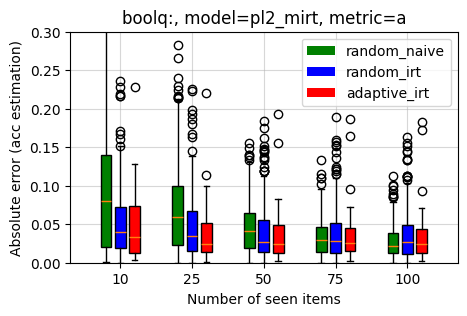

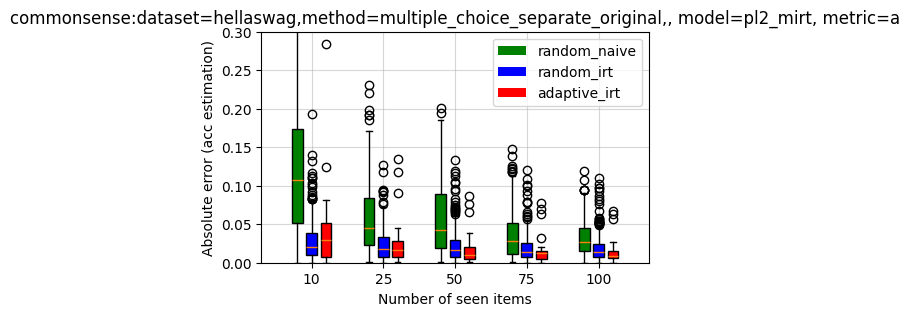

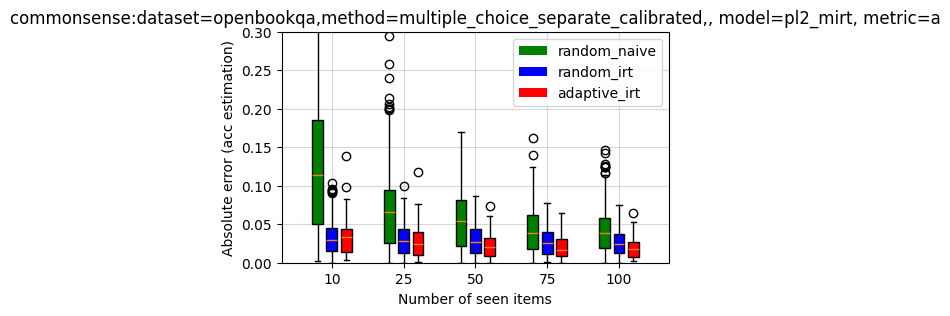

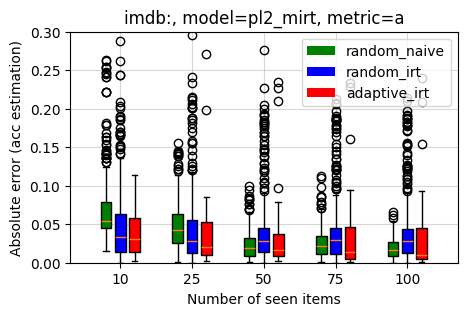

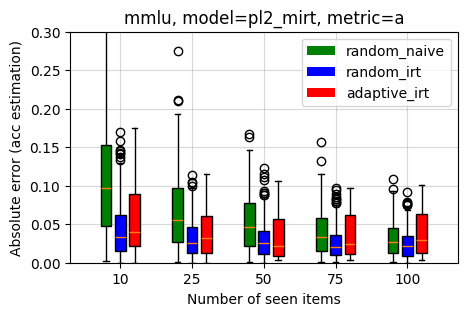

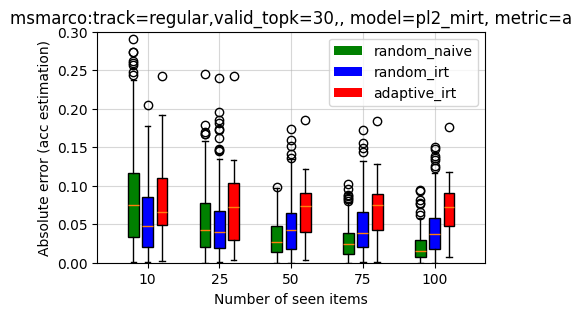

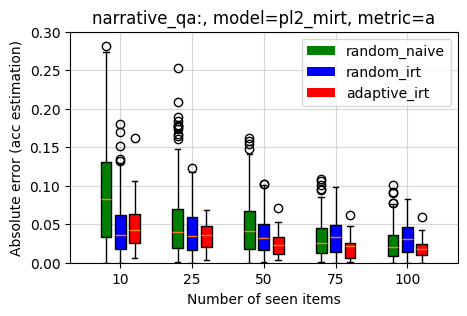

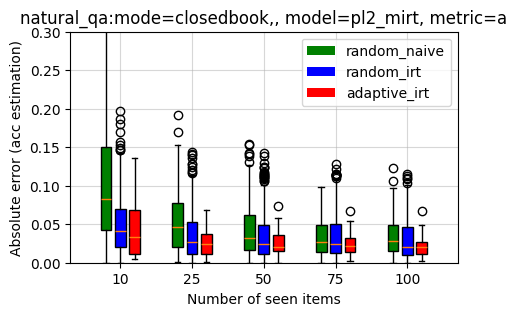

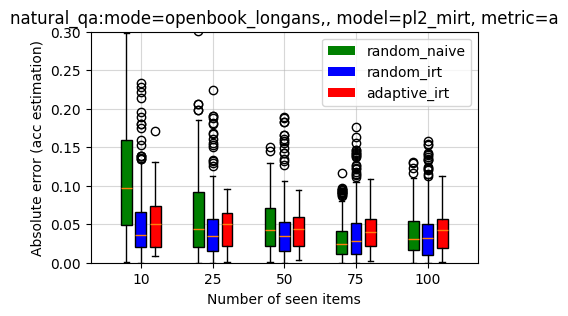

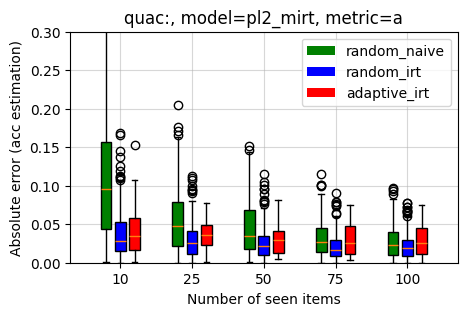

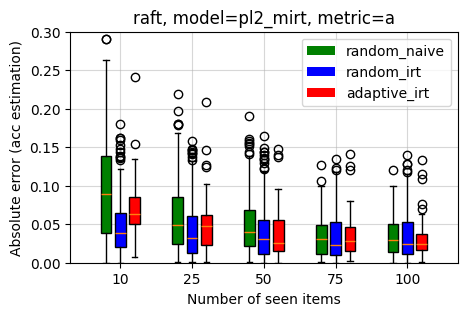

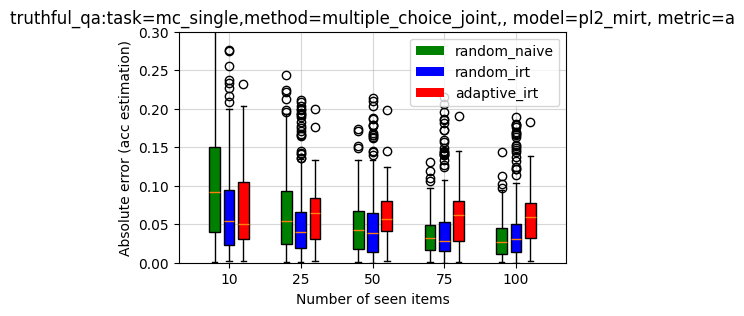

In [6]:
plot_results(results, scenarios_choosen, number_items, 'a', scenario_name, 'full')

In [10]:
import pickle

with open('r4.pickle', 'wb') as handle:
    pickle.dump({'accs':accs, 'res':results}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
methods = ['random_naive', 'random_irt', 'adaptive_irt']

In [8]:
l = scenarios.keys()

In [9]:
cons_results = {}

for scenario in l: 
    for method in methods:
        cons_results[method] = {}
        for number_item in number_items:
            cons_results[method][number_item] = []
            
for scenario in l: 
    for method in methods:
        for number_item in number_items:
            cons_results[method][number_item]+=[np.mean([results[model][number_item][method][scenario] for model in results.keys()])]

In [10]:
def plot_results2(results, number_items, methods):

    irt_model = 'pl2_mirt'
    colors = ['green', 'blue', 'red', 'yellow']

    results2 = {}
    for method in methods:
        results2[method] = np.array([results[method][number_item] for number_item in number_items]).T


    for i in range(len(number_items)):
        positions = [i - 0.2, i, i + 0.2]
        for pos, d, color in zip(positions, [np.array(results2[method])[:, i] for method in methods], colors):
            plt.boxplot(d, positions=[pos], patch_artist=True, showfliers=False, showmeans=True, boxprops=dict(facecolor=color))
    plt.xlabel("Number of seen items (per scenario)")
    plt.ylabel("Absolute error (acc estimation)")
    plt.ylim(0, 0.15)
    plt.grid(alpha=.5)
    xticks = [i for i in range(len(number_items))]
    plt.xticks(xticks, [str(number_item) for number_item in number_items])
    legend_elements = [Patch(facecolor=color, label=group) for group, color in zip(methods, colors)]
    plt.legend(handles=legend_elements)
    #plt.savefig(f'plots/boxplot_metric-{metric}_scenario-{scenario}-{typ}.png', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

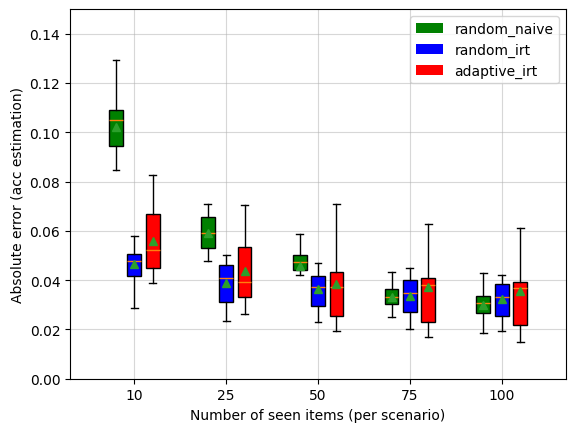

In [11]:
plot_results2(cons_results, number_items, methods)

In [12]:
l = ['boolq:',
     'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,',
     'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,',
     'imdb:',
     'mmlu',
     #'msmarco:track=regular,valid_topk=30,',
     #'narrative_qa:',
     #'natural_qa:mode=closedbook,',
     #'natural_qa:mode=openbook_longans,',
     #'quac:',
     'raft',
     'truthful_qa:task=mc_single,method=multiple_choice_joint,']

In [13]:
cons_results = {}

for scenario in l: 
    for method in methods:
        cons_results[method] = {}
        for number_item in number_items:
            cons_results[method][number_item] = []
            
for scenario in l: 
    for method in methods:
        for number_item in number_items:
            cons_results[method][number_item]+=[np.mean([results[model][number_item][method][scenario] for model in results.keys()])]

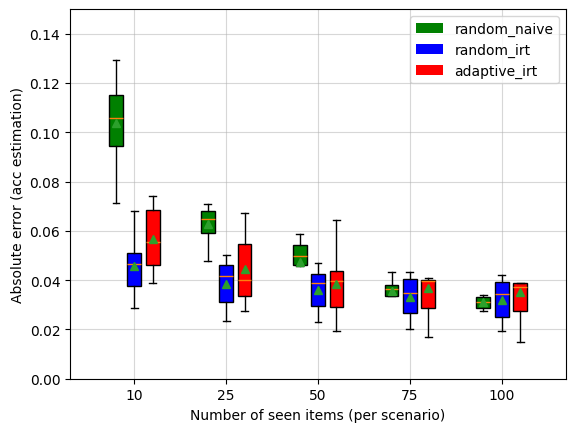

In [14]:
plot_results2(cons_results, number_items, methods)